<a href="https://colab.research.google.com/github/ViniciusKanh/EnergyMgmt-ML-Previsao/blob/main/EficienciaEnergetica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

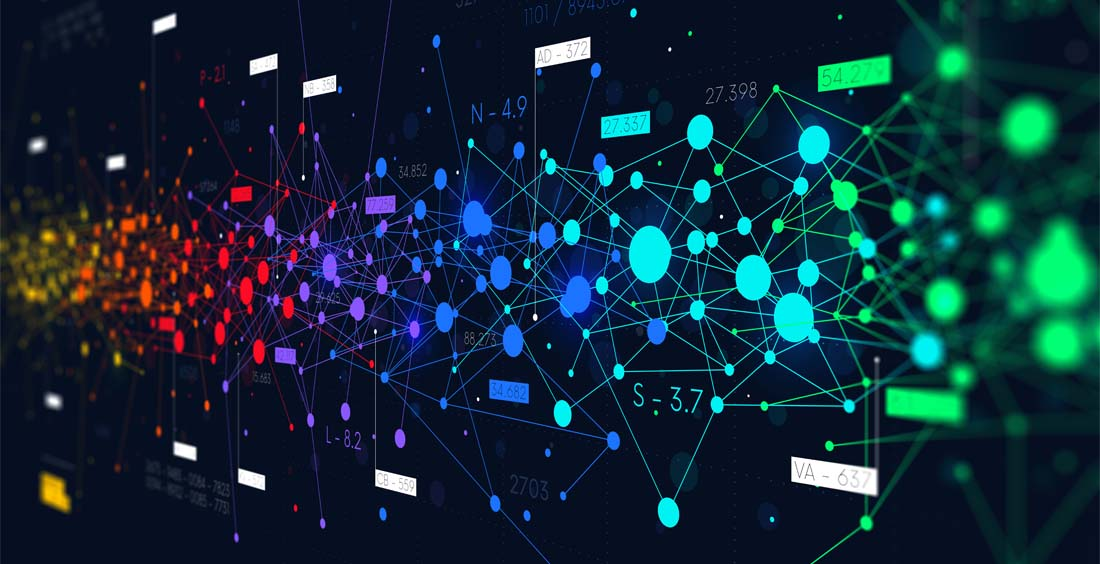
# Modelagem e Previsão de Consumo Energético em Ambientes Urbanos: Explorando o Potencial do Machine Learning na Previsão de Consumo de Energia

# Resumo do Projeto de Pesquisa 🌍

## Introdução 📖
Este projeto visa desenvolver um modelo de Floresta Aleatória para prever o consumo energético em ambientes urbanos, contribuindo para um planejamento energético mais eficiente e sustentável.

## Metodologia 🛠️
- **Pesquisa Bibliográfica**: Revisão aprofundada de literatura sobre previsão de consumo energético e machine learning.
- **Coleta e Preparação de Dados**: Tratamento de dados históricos de consumo energético.
- **Desenvolvimento do Modelo**: Implementação e ajuste da Floresta Aleatória.
- **Testes e Validação**: Avaliação da precisão do modelo.
- **Análise de Desafios**: Discussão sobre complexidade na interpretação e necessidade de dados extensos.

## Resultados Esperados 📈
Criação de um modelo preditivo eficiente para ajudar no planejamento urbano e na gestão de recursos energéticos.

## Problemas a Explorar 🔍
Investigar a capacidade do modelo em diferentes cenários urbanos e otimizar a gestão da energia nas cidades.


# **Conclusão**
### O projeto conseguiu modelar e prever eficazmente o consumo de energia em diferentes zonas de Tetouan utilizando Floresta Aleatória e técnicas de análise distribuída. Os resultados são promissores para a implementação de estratégias de gestão de energia mais eficientes na cidade.

Monstando driver no colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Processo 1 - Pré Processamento

Importando Bibiotencas

In [ ]:
import pandas as pd
import numpy as np
from missingno import matrix

Definindo Funçoes para o Pré-Processamento

In [ ]:
def transform_consumo_to_float(df, column_name):
    df[column_name] = df[column_name].str.replace(',', '.').astype(float)
    return df

def UpdateMissingValues(df, column, method="median", number=0):
    if method == 'number':
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        median = round(df[column].median(), 2)
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        mean = round(df[column].mean(), 2)
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)

def verify_invalid_values(df):
    # Exemplo: Verificar se há algum valor negativo na coluna 'Temperatura'
    if (df['Temperatura'] < 0).any():
        print("Valores inválidos encontrados na coluna 'Temperatura'")
        # Aqui você pode adicionar um tratamento específico, por exemplo, substituir por NaN
        df['Temperatura'] = df['Temperatura'].apply(lambda x: np.nan if x < 0 else x)
    return df

"""Detecção e Exclusão de Outliers na coluna 'Consumo de energia Zona 1'"""

def get_outliers_indices(df, col_name):
    if df[col_name].dtype not in ['int64', 'float64']:  # Verifica o tipo de dados
        return []
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_indices = df[(df[col_name] < lower_bound) | (df[col_name] > upper_bound)].index
    return outliers_indices

Defindo Arquivos dos DATASETS

In [ ]:
input_file = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/BigData_Consumo_Brutos.data'
output_file = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/BigData_Consumo_Tratados.data'

# Leitura do conjunto de dados
df = pd.read_csv(input_file)

Filtragem de dados

In [ ]:
zona_columns = ['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']
for zona in zona_columns:
    df = df[df[zona] > 0]

Detecção e exclusão de outliers

In [ ]:
cols_for_outliers = ['Temperatura', 'Umidade'] + zona_columns
all_outliers_indices = []
for col in cols_for_outliers:
    outlier_indices = get_outliers_indices(df, col)
    if outlier_indices.size > 0:
        print(f"Outliers encontrados na coluna {col}.")
        all_outliers_indices.extend(outlier_indices.tolist())

# Remoção de outliers
all_outliers_indices = list(set(all_outliers_indices))
df.drop(index=all_outliers_indices, inplace=True)

Outliers encontrados na coluna Temperatura.
Outliers encontrados na coluna Umidade.
Outliers encontrados na coluna Consumo de energia da Zona 2.
Outliers encontrados na coluna Consumo de energia da Zona 3.


Informações gerais dos dados

In [ ]:
print("INFORMAÇÕES GERAIS DOS DADOS\n")
print(df.info())
print("\n")


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50931 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DateTime                      50931 non-null  object 
 1   Temperatura                   50931 non-null  float64
 2   Umidade                       50931 non-null  float64
 3   Velocidade do Vento           50931 non-null  float64
 4   fluxos difusos gerais         50931 non-null  float64
 5   fluxos difusos                50931 non-null  float64
 6   Consumo de energia da Zona 1  50931 non-null  float64
 7   Consumo de energia da Zona 2  50931 non-null  float64
 8   Consumo de energia da Zona 3  50931 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.9+ MB
None




Descrição dos dados

In [ ]:
print("DESCRIÇÃO DOS DADOS\n")
print(df.describe())
print("\n")

DESCRIÇÃO DOS DADOS

        Temperatura       Umidade  Velocidade do Vento  fluxos difusos gerais  \
count  50931.000000  50931.000000         50931.000000           50931.000000   
mean      18.525163     68.759261             1.887038             183.792065   
std        5.609711     14.968768             2.331118             264.023725   
min        3.247000     23.770000             0.050000               0.004000   
25%       14.310000     58.830000             0.077000               0.062000   
50%       18.510000     70.100000             0.085000               5.633000   
75%       22.460000     81.600000             4.915000             324.650000   
max       35.540000     94.800000             6.483000            1163.000000   

       fluxos difusos  Consumo de energia da Zona 1  \
count    50931.000000                  50931.000000   
mean        75.974607                  31984.371523   
std        125.200795                   6862.063590   
min          0.011000        

Tratamento para registros faltantes

In [ ]:
columns_missing_value = df.columns[df.isnull().any()]
method = 'mean'
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)

Detecção de outliers nas zonas

In [ ]:
for zona in zona_columns:
    outlier_indices = get_outliers_indices(df, zona)
    if outlier_indices.size > 0:
        print(f"Outliers encontrados na coluna {zona}: {outlier_indices.size} registros.")
        df.drop(index=outlier_indices, inplace=True)

Outliers encontrados na coluna Consumo de energia da Zona 2: 3 registros.
Outliers encontrados na coluna Consumo de energia da Zona 3: 513 registros.


Verificar e tratar valores inválidos ou inconsistentes

In [ ]:
df = verify_invalid_values(df)

Ajustando a Coluna Datatime

In [ ]:
# Importando biblioteca adicional
from datetime import datetime

# Função para converter e extrair características da coluna DateTime
def process_datetime(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df['hour'] = df[datetime_col].dt.hour
    df['day_of_week'] = df[datetime_col].dt.dayofweek
    df['month'] = df[datetime_col].dt.month
    # Adicione mais extrações conforme necessário
    return df

# Aplicando a função no DataFrame
df = process_datetime(df, 'DateTime')

Reomvendo Colunas irrelevante para a construção do modelo

In [ ]:
colunas_para_remover = ['Velocidade do Vento', 'fluxos difusos gerais', 'fluxos difusos']
df.drop(columns=colunas_para_remover, inplace=True)

Salvar arquivo tratado

In [ ]:
df.to_csv(output_file, header=True, index=False)

## Processo 2 - Analise Exploratória dos Dados

## 📊 Análise Exploratória de Dados (EDA) - Resumo

### Importância da EDA
- **Visão Geral dos Dados**: A EDA proporciona um entendimento inicial e completo dos dados, crucial para qualquer análise posterior. 🌟
- **Identificação de Padrões**: Revela padrões, anomalias e tendências nos dados, essenciais para entender o comportamento do consumo de energia. 🔍
- **Fundamento para Modelagem**: As descobertas da EDA orientam a escolha de modelos de machine learning e técnicas de análise mais adequadas. 🚀
- **Decisões Baseadas em Dados**: Facilita a tomada de decisões informadas, otimizando a eficiência e eficácia do projeto. 📈

### Técnicas Utilizadas na EDA
- **Estatísticas Descritivas**: Resumo numérico das variáveis. 📉
- **Análise de Séries Temporais**: Compreensão de padrões temporais no consumo. ⏳
- **Análise de Correlação**: Relações entre diferentes variáveis. 🔗
- **Distribuição de Variáveis**: Visão sobre a natureza dos dados. 📊
- **Boxplots**: Distribuição e outliers por zona. 📦
- **Análise de Padrões Temporais**: Variações diárias no consumo. 🕒
- **Análise de Tendências e Sazonalidade**: Mudanças de longo prazo. 📆
- **PCA e Análise de Cluster**: Redução de dimensionalidade e identificação de agrupamentos. 🧩


## Estatísticas descritivas básicas


In [ ]:
file = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/BigData_Consumo_Tratados.data'

# Leitura do conjunto de dados
df = pd.read_csv(file)

print(df.describe())


        Temperatura       Umidade  Consumo de energia da Zona 1  \
count  50415.000000  50415.000000                  50415.000000   
mean      18.434703     68.872620                  31882.760228   
std        5.552078     14.879642                   6812.456458   
min        3.247000     23.770000                  13895.696200   
25%       14.270000     59.000000                  26075.401890   
50%       18.440000     70.200000                  31924.908500   
75%       22.320000     81.600000                  36658.013250   
max       35.540000     94.800000                  49360.529800   

       Consumo de energia da Zona 2  Consumo de energia da Zona 3  \
count                  50415.000000                  50415.000000   
mean                   20697.580657                  17135.261982   
std                     4958.642348                   5616.567836   
min                     8560.081466                   5935.174070   
25%                    16833.806875                

## 📈 Análise Estatística Descritiva dos Dados

### 🌡️ Temperatura
- **Quantidade**: 50.415 registros
- **Média**: 18.43°C
- **Desvio Padrão**: 5.55°C
- **Mínimo**: 3.25°C
- **1º Quartil**: 14.27°C
- **Mediana**: 18.44°C
- **3º Quartil**: 22.32°C
- **Máximo**: 35.54°C

### 💧 Umidade
- **Média**: 68.87%
- **Desvio Padrão**: 14.88%
- **Mínimo**: 23.77%
- **1º Quartil**: 59%
- **Mediana**: 70.2%
- **3º Quartil**: 81.6%
- **Máximo**: 94.8%

### 🔌 Consumo de Energia (Zona 1)
- **Média**: 31.882 kWh
- **Desvio Padrão**: 6.812 kWh
- **Mínimo**: 13.896 kWh
- **1º Quartil**: 26.076 kWh
- **Mediana**: 31.925 kWh
- **3º Quartil**: 36.658 kWh
- **Máximo**: 49.361 kWh

### 🔌 Consumo de Energia (Zona 2)
- **Média**: 20.698 kWh
- **Desvio Padrão**: 4.959 kWh
- **Mínimo**: 8.560 kWh
- **1º Quartil**: 16.834 kWh
- **Mediana**: 20.583 kWh
- **3º Quartil**: 24.121 kWh
- **Máximo**: 35.323 kWh

### 🔌 Consumo de Energia (Zona 3)
- **Média**: 17.135 kWh
- **Desvio Padrão**: 5.617 kWh
- **Mínimo**: 5.935 kWh
- **1º Quartil**: 12.950 kWh
- **Mediana**: 16.233 kWh
- **3º Quartil**: 20.405 kWh
- **Máximo**: 32.301 kWh

### ⏰ Hora do Dia
- **Variação**: 0 a 23 horas
- **Média**: 11.21 horas
- **Desvio Padrão**: 6.85 horas

### 📅 Dia da Semana
- **Variação**: 0 (Domingo) a 6 (Sábado)
- **Média**: Aprox. 3 (Quarta-feira)

### 📆 Mês
- **Variação**: 1 (Janeiro) a 12 (Dezembro)
- **Média**: 6.48 (Meio do Ano)


Analise de Series Temporais

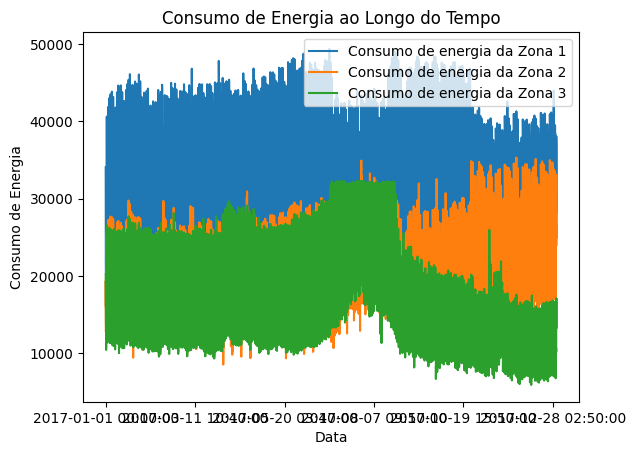

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de série temporal para consumo de energia
df.plot(x='DateTime', y=['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3'])
plt.title('Consumo de Energia ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Consumo de Energia')
plt.show()


## 🕒 Análise de Séries Temporais - Consumo de Energia

O gráfico mostra claramente padrões distintos no consumo de energia ao longo do tempo para as três zonas. 👀

- **Zona 1**: Apresenta o maior consumo, com picos e um padrão relativamente estável. 📈
- **Zona 2 e 3**: Menor consumo, mas com variações evidentes que podem refletir mudanças sazonais ou eventos específicos. 🌊📉

### Insights para Predição 🎯
- A **consistência** na Zona 1 sugere **previsibilidade**, enquanto as flutuações nas Zonas 2 e 3 podem exigir modelos que capturam **tendências temporais** e **sazonalidade**.
- O **sobrepõe** dos dados indica interdependência no consumo entre zonas, o que pode ser crucial para **modelos multivariados**.
- **Anomalias** e **picos** precisam ser considerados, pois podem influenciar a precisão das previsões. ⚠️

Estes insights são fundamentais para o desenvolvimento de um modelo de predição robusto e confiável. 🔍📊


## Análise de Correlação


<ipython-input-12-5cbac5d62f7f>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



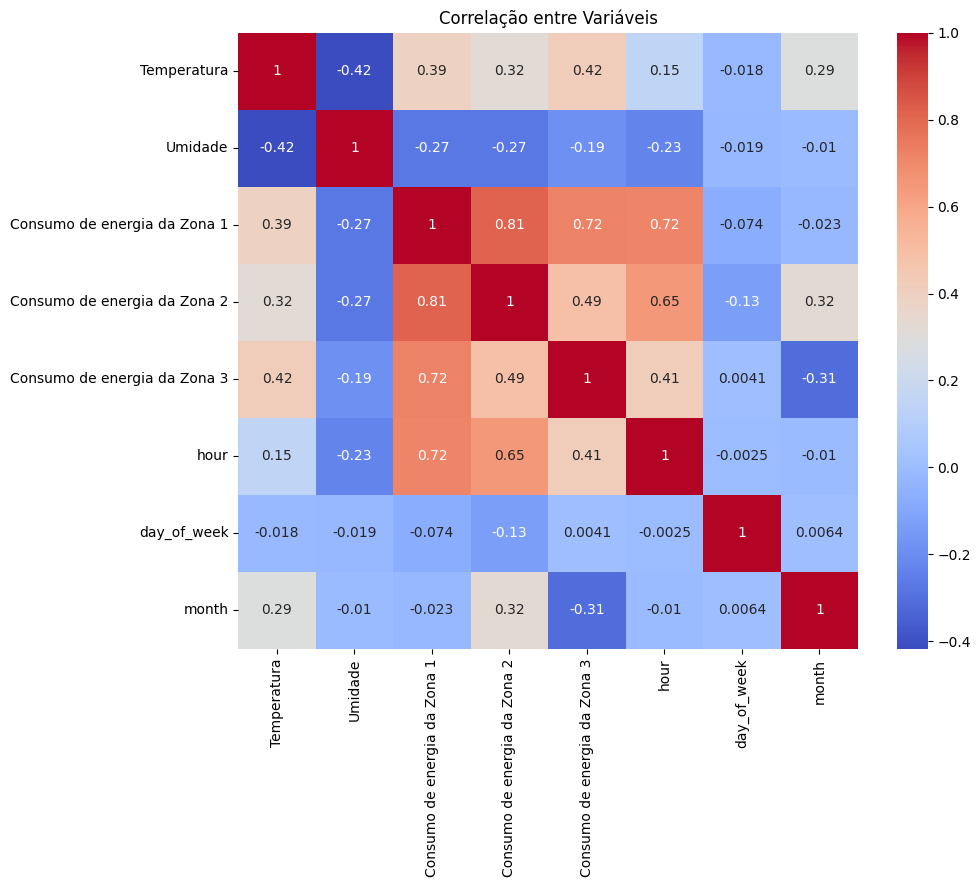

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre Variáveis')
plt.show()


## 🔗 Análise de Correlação - Insights Detalhados

A matriz de correlação fornece um panorama das relações entre variáveis. Vejamos as descobertas chave:

### Temperatura 🌡️
- **Positivamente** correlacionada com o consumo nas **Zonas 1 e 3** (0.39 e 0.42).
- Indica que o aumento da temperatura pode levar a um maior consumo de energia nessas zonas.

### Umidade 💦
- **Negativamente** correlacionada com a temperatura e o consumo de energia.
- Sugerindo que dias mais úmidos podem ter temperaturas mais baixas e menos uso de sistemas de aquecimento ou refrigeração.

### Consumo de Energia 🔋
- As zonas mostram **alta correlação positiva** entre si, especialmente **Zona 1 e Zona 2** (0.81).
- Isso pode refletir um comportamento de consumo similar ou dispositivos compartilhados que afetam múltiplas zonas.

### Hora do Dia ⏰
- Relação **forte** com o consumo, especialmente na **Zona 1** (0.72).
- Aponta para padrões de consumo diários, como o aumento de uso durante certas horas.

### Dia da Semana e Mês 📆
- Correlações **fracas** indicam que essas variáveis têm menos influência direta sobre o consumo.

Essas relações são essenciais para criar modelos preditivos precisos. Modelos que consideram essas correlações podem captar melhor a dinâmica do consumo de energia. 📈🧠


## Distribuição de Variaveis

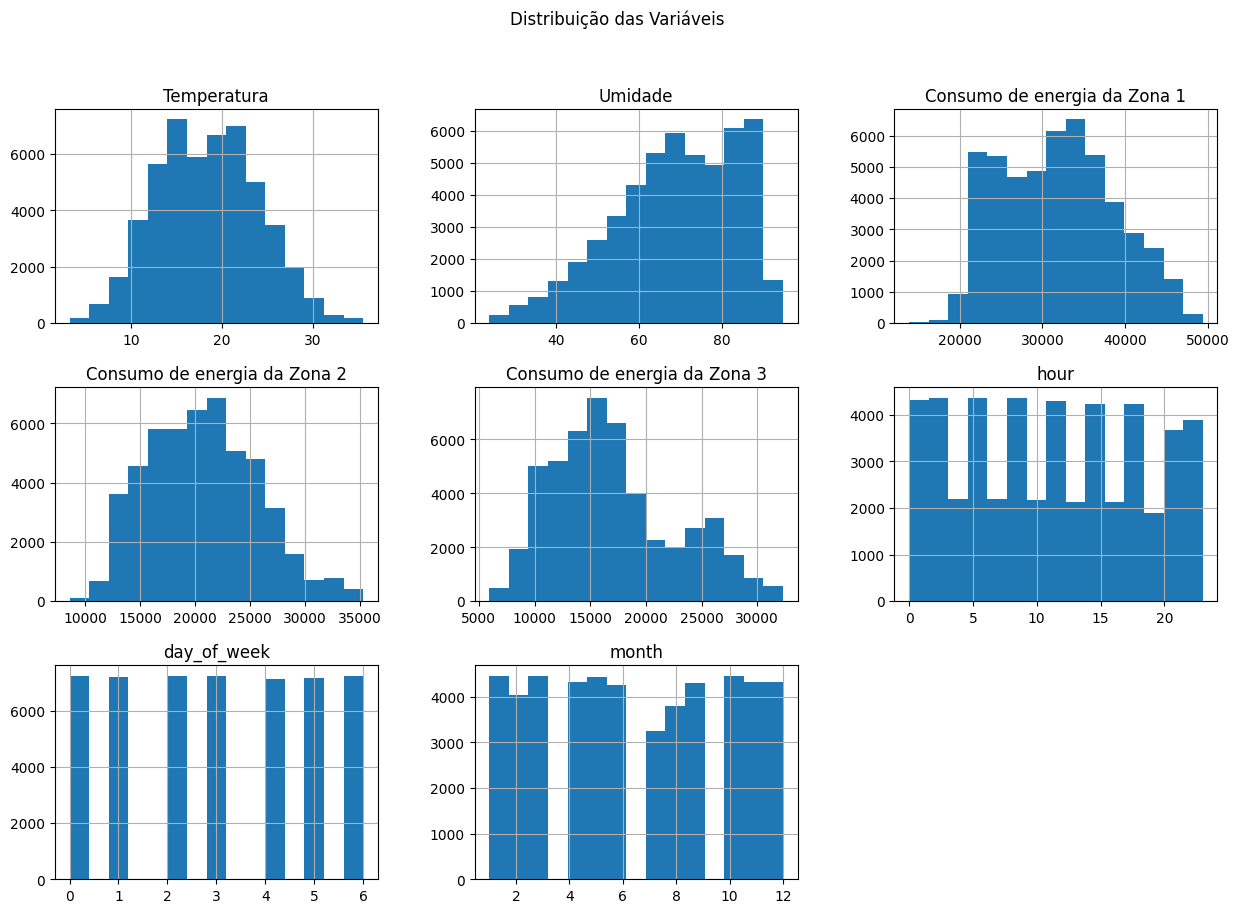

In [ ]:
# Histogramas para cada variável
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis')
plt.show()


## 📊 Distribuição das Variáveis

A análise das distribuições nos oferece insights sobre a forma e a variabilidade dos dados:

### Temperatura 🌡️
- A distribuição é aproximadamente normal com leve assimetria para a esquerda, sugerindo variação moderada na temperatura.

### Umidade 💧
- A distribuição é assimétrica para a direita, indicando dias com umidade mais alta mais frequentes.

### Consumo de Energia 🔌
- Zonas 1, 2 e 3 mostram distribuições assimétricas para a direita, o que pode indicar picos de consumo em momentos específicos.

### Hora do Dia ⏲️
- Distribuição uniforme, refletindo o ciclo diário completo de 24 horas.

### Dia da Semana 📅
- Distribuição relativamente uniforme, implicando que o dia da semana pode ter menos influência no consumo de energia.

### Mês 🗓️
- Variabilidade mensal, com picos que podem representar variações sazonais no consumo de energia.

Essas distribuições são cruciais para moldar o processo de predição, enfatizando a necessidade de considerar a sazonalidade e os padrões diários. 🔄🔮


## Boxplot para consumo de energia em cada zona


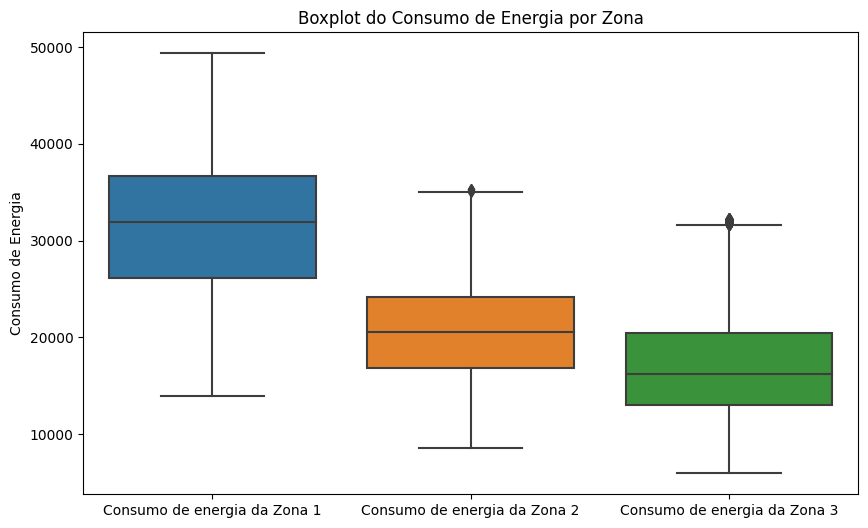

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']])
plt.title('Boxplot do Consumo de Energia por Zona')
plt.ylabel('Consumo de Energia')
plt.show()

## 📦 Boxplot do Consumo de Energia por Zona

O boxplot oferece uma visão comparativa da variação do consumo de energia entre as três zonas:

- **Zona 1 (Azul)**: Maior mediana, indicando consumo de energia mais elevado. A presença de outliers acima sugere picos de consumo.
- **Zona 2 (Laranja)**: Mediana mais baixa que a Zona 1, e maior variação interquartil, sugerindo uma variação de consumo mais ampla.
- **Zona 3 (Verde)**: Mediana ainda menor, com variação semelhante à Zona 2, e outliers acima e abaixo, indicando flutuações esporádicas no consumo.

Os boxplots ajudam a identificar onde os modelos de predição devem focar, especialmente no tratamento de outliers que podem afetar a precisão. 🔄🔮


## Analise de Padrões Temporais

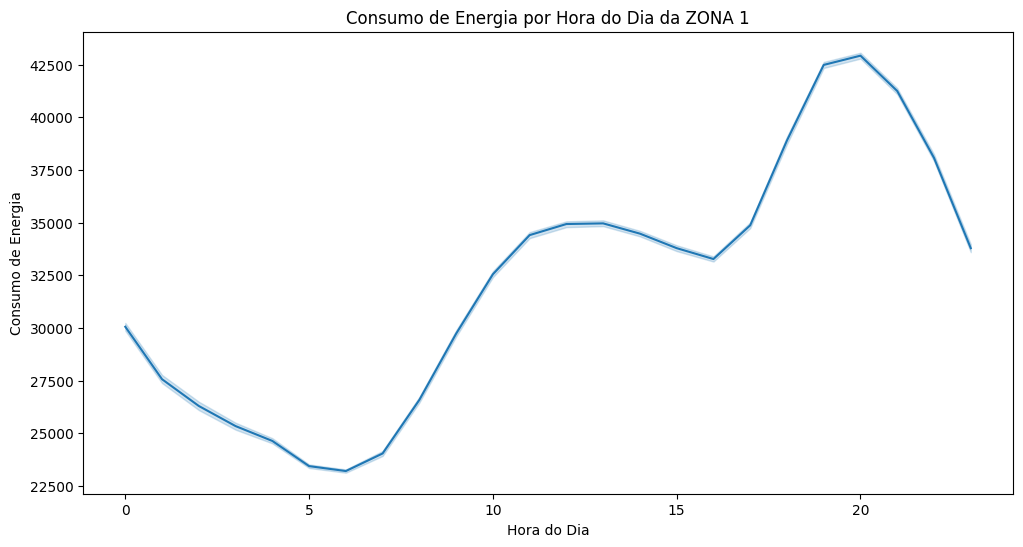

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Consumo de energia da Zona 1', data=df)
plt.title('Consumo de Energia por Hora do Dia da ZONA 1')
plt.xlabel('Hora do Dia')
plt.ylabel('Consumo de Energia')
plt.show()

## 🕓 Análise de Padrões Temporais na Zona 1

O gráfico exibe variações no consumo de energia na Zona 1 ao longo do dia:

- Observa-se um **declínio** no consumo nas primeiras horas, atingindo um **mínimo** no início da manhã.
- Há um **aumento acentuado** no consumo a partir do meio da manhã, que se estabiliza durante o dia.
- No final da tarde para a noite, registra-se um **pico**, sugerindo maior atividade e uso de energia.
- O consumo diminui novamente à medida que a noite avança.

Esses padrões são cruciais para a predição, indicando **horários de pico** que devem ser considerados para a eficiência energética e planejamento de carga. ⚡📊


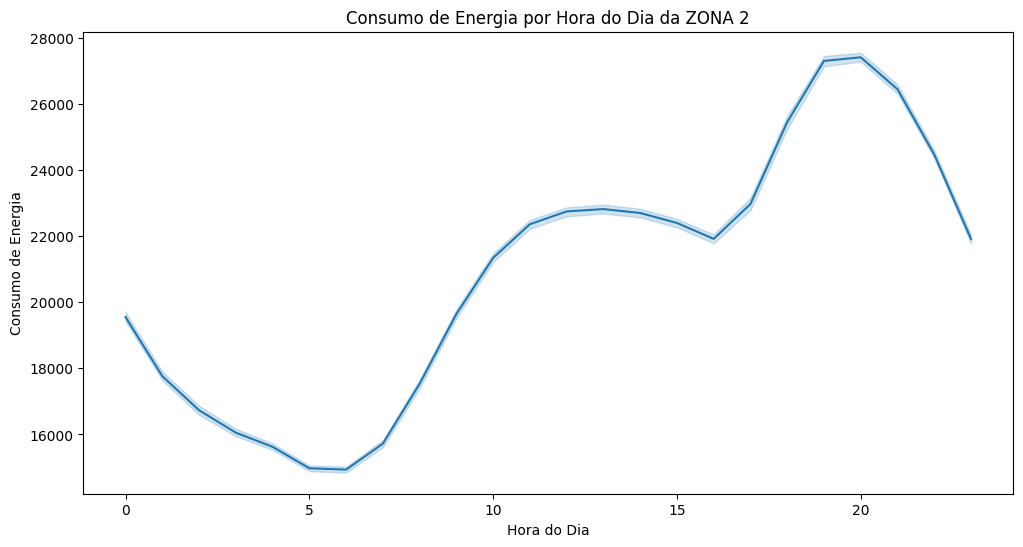

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Consumo de energia da Zona 2', data=df)
plt.title('Consumo de Energia por Hora do Dia da ZONA 2')
plt.xlabel('Hora do Dia')
plt.ylabel('Consumo de Energia')
plt.show()

## 🕑 Análise de Padrões Temporais na Zona 2

A análise do gráfico mostra o consumo de energia na Zona 2 ao longo do dia:

- **Madrugada**: O consumo começa baixo, com um **mínimo** nas primeiras horas da manhã.
- **Manhã para Tarde**: Aumento progressivo, sugerindo **atividade crescente**.
- **Fim da Tarde para Noite**: Pico significativo no consumo, possivelmente devido ao **uso residencial** após o trabalho.
- **Noite Avançada**: Queda abrupta, marcando o **fim das atividades diárias**.

Esses padrões indicam os períodos críticos que devem ser considerados na **otimização do fornecimento de energia** e na **modelagem preditiva**. 💡


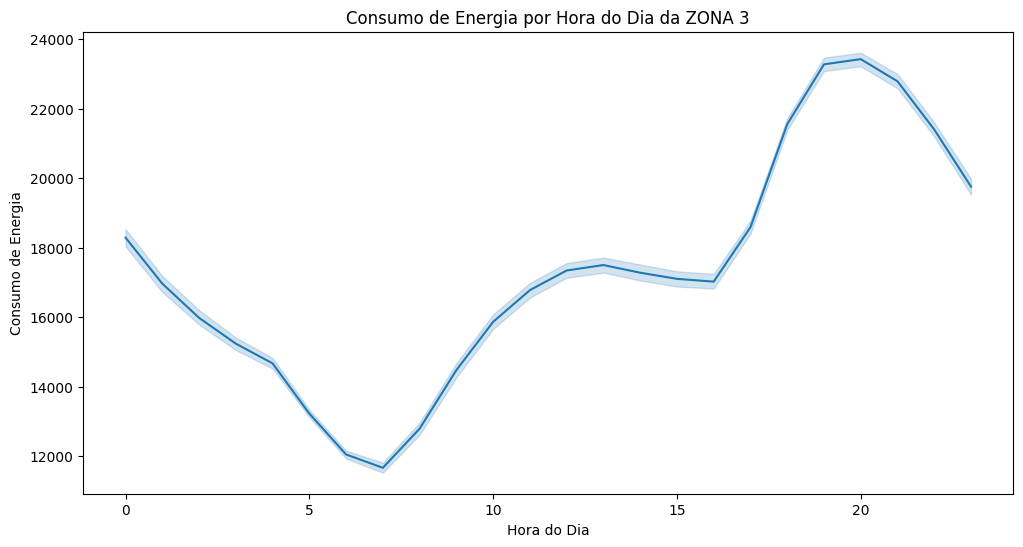

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='Consumo de energia da Zona 3', data=df)
plt.title('Consumo de Energia por Hora do Dia da ZONA 3')
plt.xlabel('Hora do Dia')
plt.ylabel('Consumo de Energia')
plt.show()

## 🕒 Análise de Padrões Temporais na Zona 3

O gráfico mostra a dinâmica do consumo de energia na Zona 3 ao longo do dia:

- **Baixo consumo** nas primeiras horas, com um **mínimo** nas horas da madrugada.
- **Aumento acentuado** no consumo inicia após o amanhecer, continuando pela manhã.
- **Estabilização** durante o meio do dia, seguido de um **pico** no início da noite.
- **Queda** no consumo à medida que a noite avança.

Estes padrões temporais sugerem um comportamento consistente com atividades diárias e residenciais, fornecendo pistas vitais para a modelagem preditiva.


## Análise de Tendências e Sazonalidade

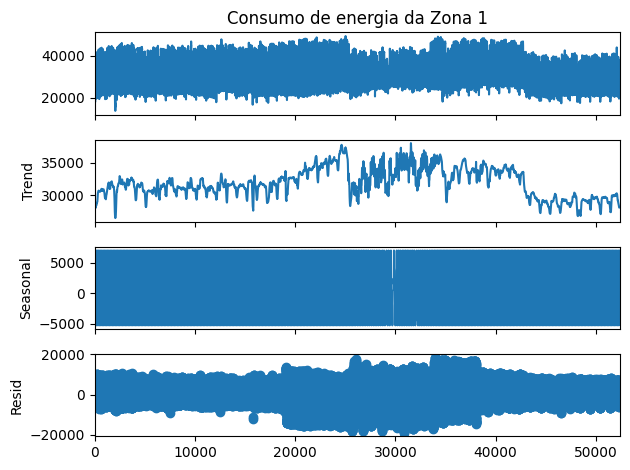

In [ ]:
# Descomposição de série temporal (requer statsmodels)
from statsmodels.tsa.seasonal import seasonal_decompose

# Exemplo para uma zona específica
result = seasonal_decompose(df['Consumo de energia da Zona 1'], model='additive', period=24*60//10)
result.plot()
plt.show()

## 📈 Análise de Tendências e Sazonalidade - Zona 1

A decomposição da série temporal do consumo de energia na Zona 1 revela:

- **Nível (Topo)**: Consumo estável com pequenas flutuações, indicando demanda consistente.
- **Tendência (Segundo gráfico)**: Variações suaves ao longo do tempo, sem tendências de subida ou descida acentuadas.
- **Sazonalidade (Terceiro gráfico)**: Padrões repetitivos não são claramente visíveis, sugerindo sazonalidade mínima ou complexa.
- **Resíduos (Fundo)**: Oscilações e irregularidades que não são explicadas pela tendência ou sazonalidade, indicando outros fatores influenciando o consumo.

Estes insights orientam para um modelo preditivo que considere efeitos não-sazonais e padrões irregulares. 🔄🕵️‍♂️


## Análise de Componentes Principais (PCA)

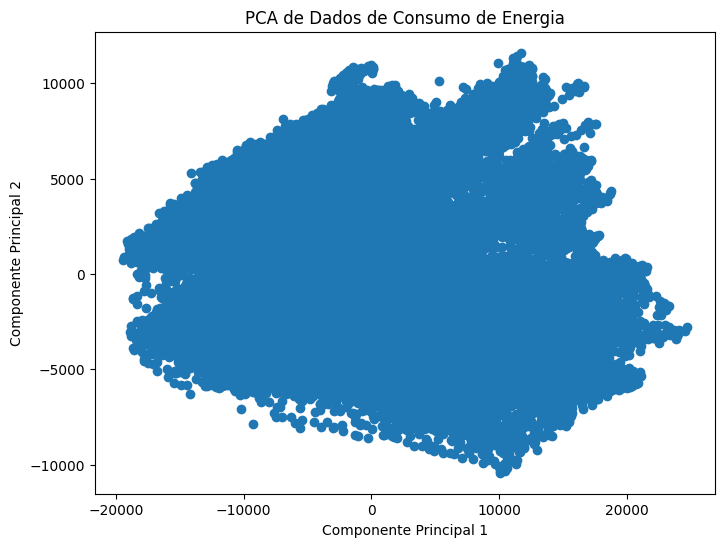

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Selecionando as colunas numéricas para PCA
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df[numeric_cols])

# Visualização
plt.figure(figsize=(8, 6))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de Dados de Consumo de Energia')
plt.show()


## 🌀 Análise de Componentes Principais (PCA)

A dispersão no PCA sugere:

- 🧩 Complexidade nos padrões de consumo energético.
- 🔄 Ausência de grupos distintos, indicando variabilidade no uso de energia.
- 🔍 Dificuldade em distinguir comportamentos de consumo específicos.

Para a predição, isso implica:

- 🤔 A necessidade de modelos analíticos mais sofisticados.
- 📊 Possível integração de mais dados para refinar a modelagem preditiva.
- 🎯 Foco em técnicas avançadas para capturar nuances nos dados.


## Análise de Cluster

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


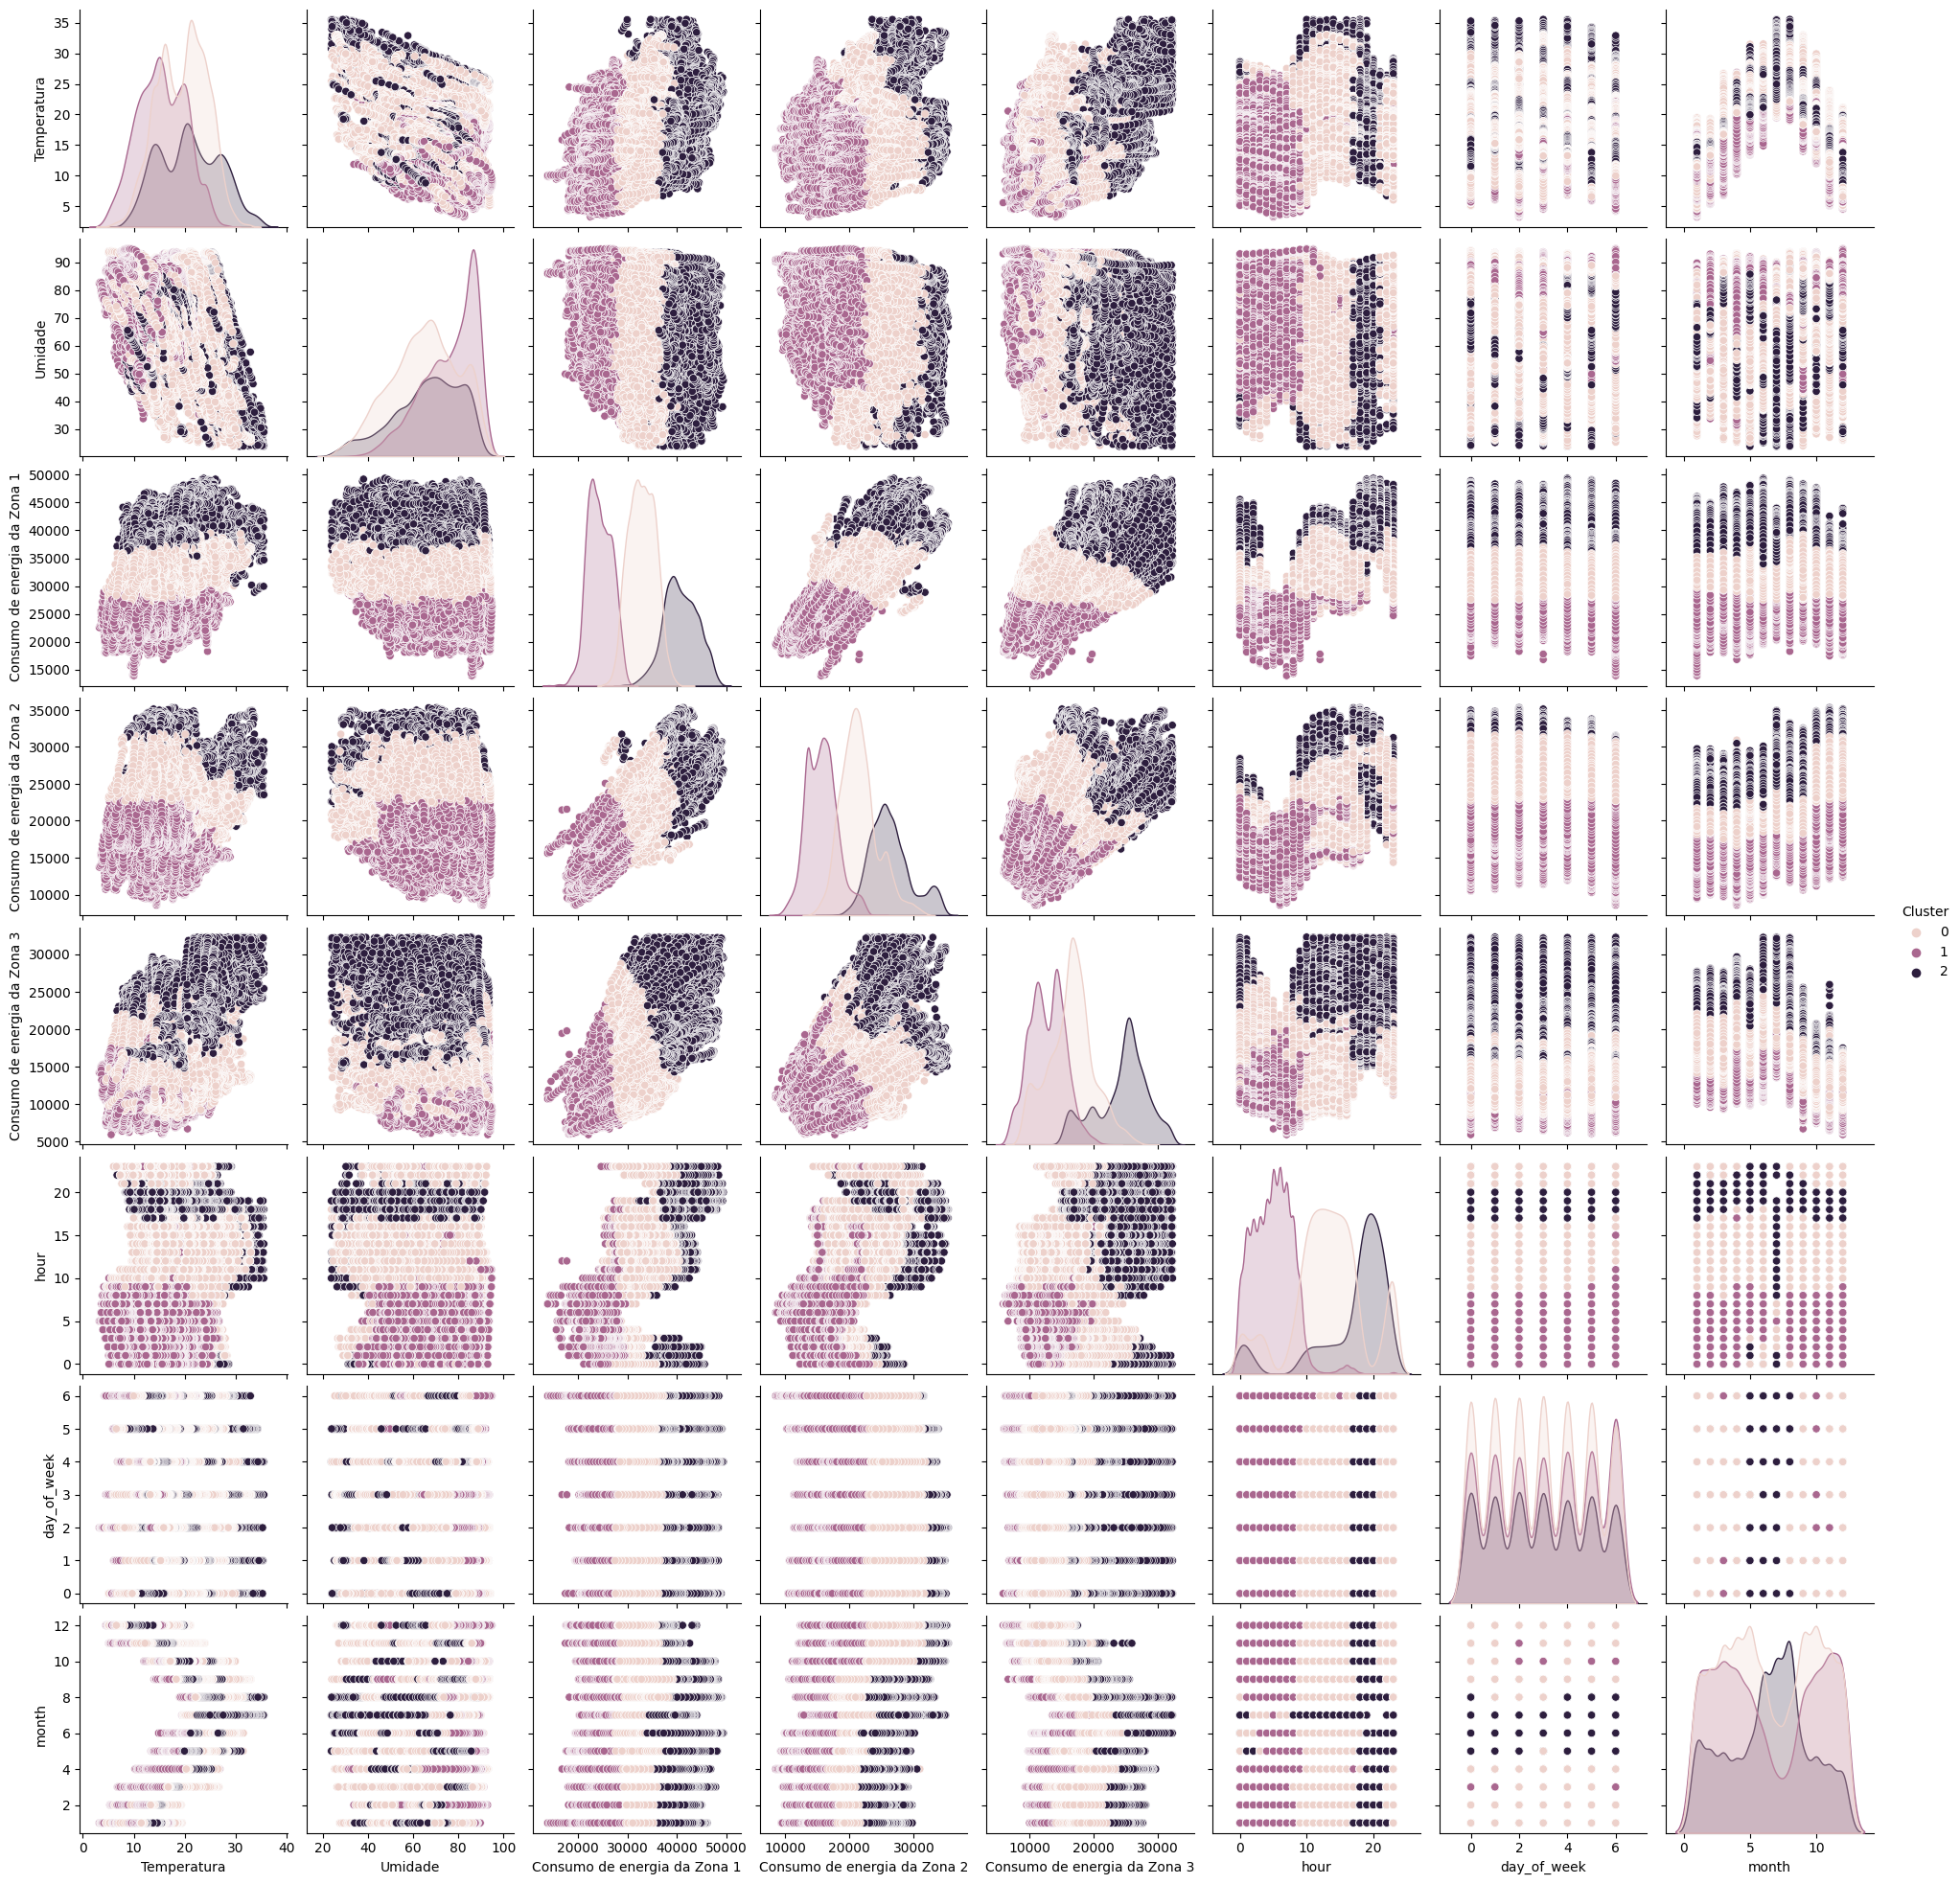

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

# Aplicando KMeans
kmeans = KMeans(n_clusters=3)  # Ajuste o número de clusters
clusters = kmeans.fit_predict(df[numeric_cols])

# Visualização
df['Cluster'] = clusters
sns.pairplot(df, hue='Cluster', vars=numeric_cols)


## Gráficos de Dispersão

## 📊 Análise de Cluster - Visão Detalhada

- Os gráficos de dispersão 👥 mostram a inter-relação entre as variáveis, com a coloração indicando diferentes grupos ou comportamentos de consumo.
- As distribuições nas margens destacam a variação das variáveis individuais 📈, como temperatura e umidade, e sua relação com o consumo de energia.
- As sobreposições de cor em certos gráficos sugerem áreas onde os clusters se misturam, o que pode ser um sinal de padrões de consumo compartilhados 🔄.
- A análise de cluster pode ser usada para identificar perfis de consumo, que são fundamentais para a previsão e gestão de energia 🔮.

Essas informações são cruciais para entender a dinâmica do consumo de energia e desenvolver estratégias de previsão eficazes. 🌟


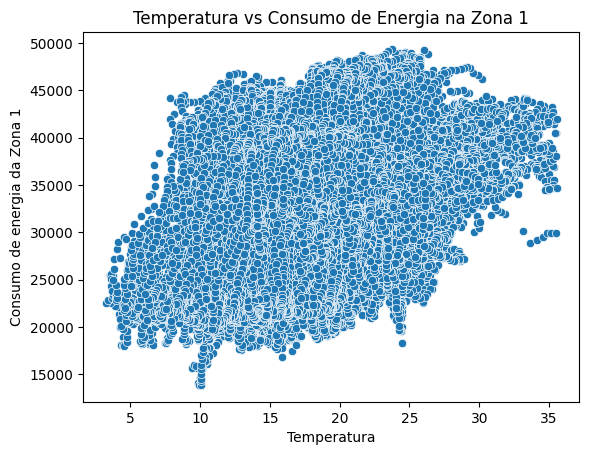

In [ ]:
sns.scatterplot(data=df, x='Temperatura', y='Consumo de energia da Zona 1')
plt.title('Temperatura vs Consumo de Energia na Zona 1')
plt.show()


## 🌡️ Temperatura vs Consumo de Energia na Zona 1

- O gráfico apresenta a relação entre temperatura e consumo de energia na Zona 1.
- Não há um padrão linear claro, indicando que a temperatura sozinha não pode prever o consumo de energia de forma confiável.
- Alguns aglomerados sugerem que em temperaturas moderadas o consumo é mais estável, enquanto em temperaturas extremas observam-se variações maiores.
- Para a modelagem preditiva, isso significa que outros fatores além da temperatura podem ter um papel significativo no consumo de energia.

Essa análise é vital para entender como a temperatura afeta o consumo de energia e para desenvolver modelos de previsão mais precisos. 🔄🔎


## Gráficos de Densidade

<ipython-input-37-9617c7ede3d0>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='Umidade', shade=True)


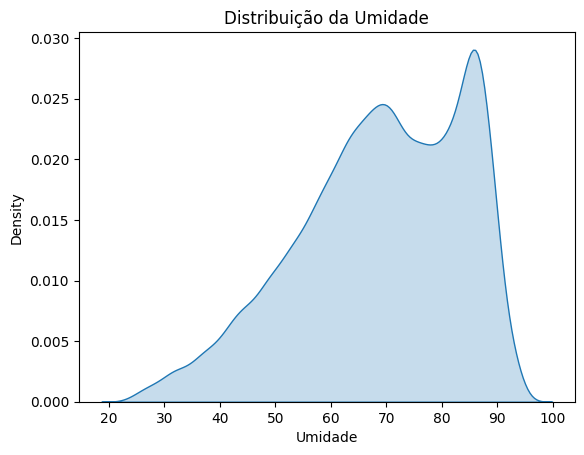

In [ ]:
sns.kdeplot(data=df, x='Umidade', shade=True)
plt.title('Distribuição da Umidade')
plt.show()


## 💧 Distribuição da Umidade

- A distribuição da umidade mostra dois picos principais, um em torno de 60% e outro acima de 90%.
- A forma bimodal da curva sugere que existem dois estados predominantes de umidade no ambiente analisado.
- O pico mais alto acima de 90% pode indicar períodos de alta umidade ou chuvas intensas.
- Para previsão, a umidade pode ser um fator relevante, especialmente se correlacionada com o consumo de energia em atividades que variam com o clima.

A compreensão da distribuição da umidade é crucial para modelar previsões que levem em consideração variações climáticas. 🌦️📈


# Dashboard

In [ ]:
!pip install dash
!pip install jupyter-dash  # Para usar Dash em Jupyter ou Colab


In [ ]:
import dash
from dash import html, dcc
import plotly.express as px

# Inicializando o app Dash
app = dash.Dash(__name__)

# Criando um DataFrame para o gráfico
df_graph = df[['DateTime', 'Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']]

# Criando o gráfico com múltiplas linhas
fig = px.line(df_graph, x='DateTime',
              y=['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3'],
              title='Consumo de Energia ao Longo do Tempo')

# Layout do app
app.layout = html.Div(children=[
    html.H1(children='Dashboard de Consumo de Energia'),

    html.Div(children='''
        Visualização do Consumo de Energia por Zona e Período.
    '''),

    dcc.Graph(
        id='energy-consumption-graph',
        figure=fig
    )
])

# Rodando o app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

## 📊 Análise Exploratória de Dados - Sumário Completo

### Estatísticas Descritivas
- **Temperatura e Umidade**: Distribuições variadas com tendências centrais claras. 🌡️💧

### Séries Temporais
- **Padrões Diários**: Consumo varia com o horário, mostrando picos no início da noite. 🌙

### Correlação
- **Inter-relacionamentos**: Altas correlações entre zonas sugerem influências ambientais compartilhadas. 🔗

### Distribuição de Variáveis
- **Bimodalidade em Umidade**: Possíveis padrões climáticos distintos. 🌦️

### Boxplots
- **Variação de Consumo**: Zona 1 tem o maior consumo; Zonas 2 e 3 são mais variáveis. 📦

### PCA
- **Complexidade**: Dados não mostram agrupamentos claros, indicando múltiplas influências no consumo. 🌀

### Análise de Cluster
- **Agrupamentos**: Falta de grupos distintos sugere complexidade na modelagem. 👥

### Gráficos de Dispersão
- **Temperatura vs Consumo**: Relações não-lineares que requerem análise aprofundada. 🌡️🔋

### Modelo de Previsão Recomendado
- **Floresta Aleatória ou Redes Neurais**: Capazes de capturar complexidades e padrões não-lineares nos dados. 🌲🧠


## Processo 3 - Criação e Avaliação do Modelo de Prediçao

## 🌳 Modelo de Floresta Aleatória

A Floresta Aleatória é um método poderoso de machine learning que opera construindo uma multitude de árvores de decisão 🌲 durante o treinamento e produzindo a classe que é o modo das classes (classificação) ou previsão média (regressão) das árvores individuais.

### Como Será Modelado e Treinado na Base de Dados 🏗️

1. **Preparação dos Dados**: Antes de treinar o modelo, os dados serão pré-processados para tratar valores faltantes, normalizar escalas e codificar variáveis categóricas.

2. **Divisão do Conjunto de Dados**: O conjunto será dividido em treino e teste para avaliar a performance do modelo.

3. **Treinamento do Modelo**: As árvores de decisão serão treinadas em diferentes subconjuntos dos dados com diferentes subconjuntos de características, aumentando a diversidade e a robustez do modelo.

4. **Ajuste de Hiperparâmetros**: Buscaremos os melhores hiperparâmetros, como o número de árvores e a profundidade máxima, através de validação cruzada.

5. **Avaliação**: O modelo será avaliado com métricas como precisão, recall e F1-score, para garantir que ele generaliza bem para dados não vistos.

6. **Importância das Características**: Analisaremos quais características são mais importantes para as previsões do modelo.

7. **Iteração**: O modelo será iterativamente ajustado e refinado para melhorar a precisão.

A Floresta Aleatória é ideal para nossos dados devido à sua capacidade de lidar com grandes conjuntos de dados com muitas variáveis de entrada e sua robustez contra overfitting. 🚀


## Estruturando o Dataset para Analise

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import joblib
import numpy as np


# Carregar o conjunto de dados
file = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/BigData_Consumo_Tratados.data'
df = pd.read_csv(file)

# Definindo as features e os targets
features = ['Temperatura', 'Umidade', 'hour', 'day_of_week', 'month']
targets = ['Consumo de energia da Zona 1', 'Consumo de energia da Zona 2', 'Consumo de energia da Zona 3']

# Preparando os dados de entrada e saída
X = df[features]
Y = df[targets]

## Dividindo o dataset

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

## Criando o Modelo

In [ ]:
# Modelo de Floresta Aleatória
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

## Treinando o Modelo

In [ ]:
# Treinando o modelo para todas as zonas simultaneamente
rf_model.fit(X_train, Y_train)

# Predições para o conjunto de teste
Y_pred = rf_model.predict(X_test)

# Avaliando o modelo com várias métricas para cada zona
for i in range(Y_test.shape[1]):
    print(f"\nMétricas para a Zona {i+1}:")
    mse = mean_squared_error(Y_test.iloc[:, i], Y_pred[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test.iloc[:, i], Y_pred[:, i])
    r2 = r2_score(Y_test.iloc[:, i], Y_pred[:, i])

    print(f"  MSE: {mse}")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R²: {r2}")


Métricas para a Zona 1:
  MSE: 1316098.2963554955
  RMSE: 1147.213274136721
  MAE: 722.0003637937657
  R²: 0.9717931884533997

Métricas para a Zona 2:
  MSE: 709954.2462275756
  RMSE: 842.587827011271
  MAE: 523.70386894351
  R²: 0.9715212495370406

Métricas para a Zona 3:
  MSE: 749553.0321617615
  RMSE: 865.767308323525
  MAE: 489.65808615854627
  R²: 0.976329598868051


## Salvando o Modelo de Previsão

In [ ]:
import joblib
import pickle

# Salvando com joblib
joblib_path = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.joblib'
joblib.dump(rf_model, joblib_path)

# Salvando com pickle
pickle_path = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.pkl'
with open(pickle_path, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"Modelo salvo em {joblib_path} e {pickle_path}")


Modelo salvo em /content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.joblib e /content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.pkl


## ONNX

ONNX é um formato aberto criado para representar modelos de machine learning e facilitar a interoperabilidade entre diferentes frameworks. Para converter um modelo de Scikit-Learn para ONNX, você precisa instalar a biblioteca onnxmltools.

In [ ]:
!pip install onnxmltools onnxconverter_common

In [ ]:
!pip install --upgrade protobuf

In [ ]:
!pip install --upgrade pip setuptools

In [ ]:
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxmltools

# Agora, você pode tentar converter o modelo novamente
onnx_model = onnxmltools.convert_sklearn(rf_model, initial_types=[('input', FloatTensorType([None, X_train.shape[1]]))])

# Salvando o modelo ONNX
onnx_path = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/modelo_rf.onnx'
onnxmltools.utils.save_model(onnx_model, onnx_path)


## 📊 Análise das Métricas de Desempenho do Modelo de Previsão

Avaliando as métricas fornecidas para cada zona, podemos determinar a eficácia do modelo de Floresta Aleatória:

### Zona 1
- **MSE (Mean Squared Error)**: 1,316,098.30
- **RMSE (Root Mean Squared Error)**: 1,147.21
- **MAE (Mean Absolute Error)**: 722.00
- **R² (Coeficiente de Determinação)**: 0.9718

### Zona 2
- **MSE**: 709,954.25
- **RMSE**: 842.59
- **MAE**: 523.70
- **R²**: 0.9715

### Zona 3
- **MSE**: 749,553.03
- **RMSE**: 865.77
- **MAE**: 489.66
- **R²**: 0.9763

### Análise e Conclusões 🧐
- **Baixos Valores de RMSE e MAE**: Indicam que o modelo tem uma boa precisão nas previsões, com erros médios e quadrados relativamente baixos. 🎯
- **Alto R²**: Valores próximos de 1 mostram que o modelo explica uma grande parte da variância nos dados, indicando um bom ajuste. 📈
- **Consistência entre Zonas**: Métricas similares para as três zonas sugerem que o modelo é igualmente eficaz em diferentes contextos. 👌

### Conclusão
- O modelo de Floresta Aleatória demonstra ser um **excelente modelo de previsão** para o consumo de energia nas três zonas, baseado nas métricas de RMSE, MAE e R². ✔️
- A **alta pontuação R²** em todas as zonas reforça a capacidade do modelo de capturar com precisão as variações no consumo de energia. 🌟
- As previsões são **confiáveis e consistentes**, tornando o modelo adequado para aplicações práticas na previsão do consumo de energia. 🌍


# Fazendo Previsões com o modelo Treinado e Avaliado

In [ ]:
!pip install dash

In [ ]:
!pip install pyngrok

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import joblib

# Carregar o modelo de previsão treinado
model_path = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.joblib'
model = joblib.load(model_path)

# Gerar datas para o ano de 2018
dates_2018 = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(365)]

# Gerar dados simulados para previsão
df_predict = pd.DataFrame({
    # Substitua estes dados simulados pelos dados reais que o seu modelo necessita
    'Temperatura': [20] * len(dates_2018),
    'Umidade': [50] * len(dates_2018),
    'hour': [12] * len(dates_2018),
    'day_of_week': [date.weekday() for date in dates_2018],
    'month': [date.month for date in dates_2018]
})

# Previsão usando o modelo
predicted_consumption = model.predict(df_predict)

# Imprimir o formato da previsão
print("Formato da previsão:", predicted_consumption.shape)

# Verificar se a previsão é uma matriz e achatá-la se necessário
if predicted_consumption.ndim > 1:
    # Se o modelo está prevendo várias saídas por entrada, escolha uma saída específica
    # Por exemplo, pegue a primeira coluna de previsões se houver várias
    predicted_consumption = predicted_consumption[:, 0]

# Certificar-se de que os tamanhos correspondem antes de criar o DataFrame
assert len(predicted_consumption) == len(dates_2018), "O número de previsões e datas deve ser o mesmo"

# Criar o DataFrame com os resultados previstos
df_results = pd.DataFrame({
    'DateTime': dates_2018,
    'Consumo Previsto': predicted_consumption
})


Formato da previsão: (365, 3)


In [ ]:
import dash
from dash import html, dcc
import plotly.express as px

# Inicializar o aplicativo Dash
app = dash.Dash(__name__)

# Criar o gráfico com as previsões
fig = px.line(df_results, x='DateTime', y='Consumo Previsto', title='Previsão de Consumo de Energia para 2018')

# Layout do app
app.layout = html.Div(children=[
    html.H1(children='Dashboard de Previsão de Consumo de Energia para 2018'),
    dcc.Graph(
        id='energy-consumption-graph',
        figure=fig
    )
])

# Rodar o app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

## Gerando Arquivo Excel de Previsão

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import joblib

# Carregar o modelo de previsão treinado
model_path = '/content/drive/My Drive/0-Dataset/Prever Consumo Tetuam/rf_model.joblib'
model = joblib.load(model_path)

# Gerar datas para o ano de 2018
dates_2018 = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(365)]

# Gerar dados simulados para previsão
df_predict = pd.DataFrame({
    # Substitua estes dados simulados pelos dados reais que o seu modelo necessita
    'Temperatura': [20] * len(dates_2018),
    'Umidade': [50] * len(dates_2018),
    'hour': [12] * len(dates_2018),
    'day_of_week': [date.weekday() for date in dates_2018],
    'month': [date.month for date in dates_2018]
})

# Previsão usando o modelo
predicted_consumption = model.predict(df_predict)

# Verificar se a previsão é uma matriz e processá-la corretamente
# Suponha que o modelo retorna previsões separadas para cada zona
if predicted_consumption.ndim > 1 and predicted_consumption.shape[1] == 3:
    df_results = pd.DataFrame({
        'DateTime': dates_2018,
        'Consumo Previsto Zona 1': predicted_consumption[:, 0],
        'Consumo Previsto Zona 2': predicted_consumption[:, 1],
        'Consumo Previsto Zona 3': predicted_consumption[:, 2]
    })
else:
    raise ValueError("Formato de previsão inesperado")

# Salvar as previsões em um arquivo Excel
excel_output_path = '/content/drive/My Drive/0-Dataset/Previsoes_Consumo_2018.xlsx'
df_results.to_excel(excel_output_path, index=False)

print("Previsões salvas em:", excel_output_path)


Previsões salvas em: /content/drive/My Drive/0-Dataset/Previsoes_Consumo_2018.xlsx
